<a href="https://colab.research.google.com/github/skywalker0803r/Ricky/blob/master/%E7%8E%89%E5%B1%B1AI%E6%AF%94%E8%B3%BD_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import warnings 
warnings.simplefilter('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# train

In [2]:
import pandas as pd
train = pd.read_csv("/content/drive/My Drive/玉山人工智慧比賽數據/train_預處理完.csv",index_col=0)
print(train.shape)
train.head()

(1521787, 23)


,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,hcefg,insfg,iterm,locdt,loctm,mcc,mchno,ovrlt,scity,stocn,stscd,txkey,fraud_ind
0,6881,113261,38038,513,5,0,0,0,0,0,5,0,0,33,172652,457,59333,0,0,102,0,516056,0
1,0,134508,45725,465,5,0,0,2,0,0,0,0,0,9,105114,451,0,0,5817,102,0,4376,0
2,6881,15408,188328,513,5,0,0,0,0,0,5,0,0,6,152458,457,59333,0,0,102,0,483434,0
3,6716,157159,29967,1016,5,62,0,5,0,0,5,0,0,5,172946,247,50436,0,3281,102,0,1407164,0
4,5975,105985,81305,713,5,62,0,4,0,0,5,0,0,6,182129,263,93775,0,5817,102,0,1051004,0


# test

In [3]:
test = pd.read_csv("/content/drive/My Drive/玉山人工智慧比賽數據/test_預處理完.csv",index_col=0)
test_txkey = test["txkey"]
print(test.shape)
test.head()

(421665, 22)


,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,hcefg,insfg,iterm,locdt,loctm,mcc,mchno,ovrlt,scity,stocn,stscd,txkey
0,6881,163188,116799,513,5,0,0,0,0,0,5,0,0,102,215328,457,59360,0,0,102,0,592489
1,6881,163188,116799,513,5,0,0,0,0,0,5,0,0,102,222007,457,59360,0,0,102,0,592452
2,6881,163188,116799,513,5,0,0,0,0,0,5,0,0,100,170013,457,59360,0,0,102,0,590212
3,6881,163188,116799,513,5,0,0,0,0,0,5,0,0,100,165914,457,59360,0,0,102,0,590209
4,6881,163188,116799,513,5,0,0,0,0,0,5,0,0,102,215311,457,59360,0,0,102,0,592488


# 有些類別在train上有但是test上根本沒出現過....

In [4]:
p = {}
for col in train.drop('fraud_ind',axis=1).columns:
  u = len(set(train[col].unique())&set(test[col].unique()))
  t = len(train[col].unique())
  p[col] = u/t 
pd.DataFrame(p,index=['p']).T.sort_values(by='p',ascending=False)

,p
insfg,1.000000
stscd,1.000000
contp,1.000000
ecfg,1.000000
etymd,1.000000
flbmk,1.000000
flg_3dsmk,1.000000
hcefg,1.000000
iterm,1.000000
ovrlt,1.000000


# 定義 features & target

In [5]:
features = test.drop(['txkey','locdt','cano','bacno'],axis=1).columns.tolist()
y_name = 'fraud_ind'
print(len(features),features)
print(len([y_name]),[y_name])

18 ['acqic', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd', 'flbmk', 'flg_3dsmk', 'hcefg', 'insfg', 'iterm', 'loctm', 'mcc', 'mchno', 'ovrlt', 'scity', 'stocn', 'stscd']
1 ['fraud_ind']


# 切分 訓練集 跟 驗證集

In [6]:
from sklearn.model_selection import train_test_split
train,val = train_test_split(train ,test_size=0.33 ,random_state=777)
print(train.shape)
print(val.shape)

(1019597, 23)
(502190, 23)


# train

[1]	train's xentropy: 0.0597151	train's f1: 0	val's xentropy: 0.0594038	val's f1: 0
Training until validation scores don't improve for 50 rounds.
[2]	train's xentropy: 0.0562223	train's f1: 0	val's xentropy: 0.0559552	val's f1: 0
[3]	train's xentropy: 0.0527338	train's f1: 0	val's xentropy: 0.0524901	val's f1: 0
[4]	train's xentropy: 0.0502162	train's f1: 0	val's xentropy: 0.0499987	val's f1: 0
[5]	train's xentropy: 0.0484327	train's f1: 0	val's xentropy: 0.0482426	val's f1: 0
[6]	train's xentropy: 0.0467326	train's f1: 0	val's xentropy: 0.0465814	val's f1: 0
[7]	train's xentropy: 0.0452776	train's f1: 0	val's xentropy: 0.0451653	val's f1: 0
[8]	train's xentropy: 0.0440877	train's f1: 0	val's xentropy: 0.044019	val's f1: 0
[9]	train's xentropy: 0.0429681	train's f1: 0	val's xentropy: 0.0429608	val's f1: 0
[10]	train's xentropy: 0.0419381	train's f1: 0.000292826	val's xentropy: 0.0419709	val's f1: 0.000298552
[11]	train's xentropy: 0.0410833	train's f1: 0.000292826	val's xentropy: 0.041

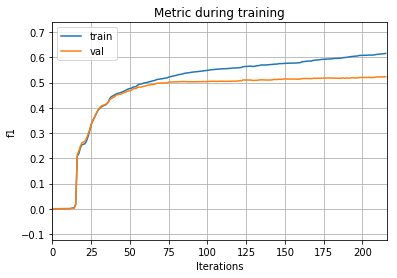

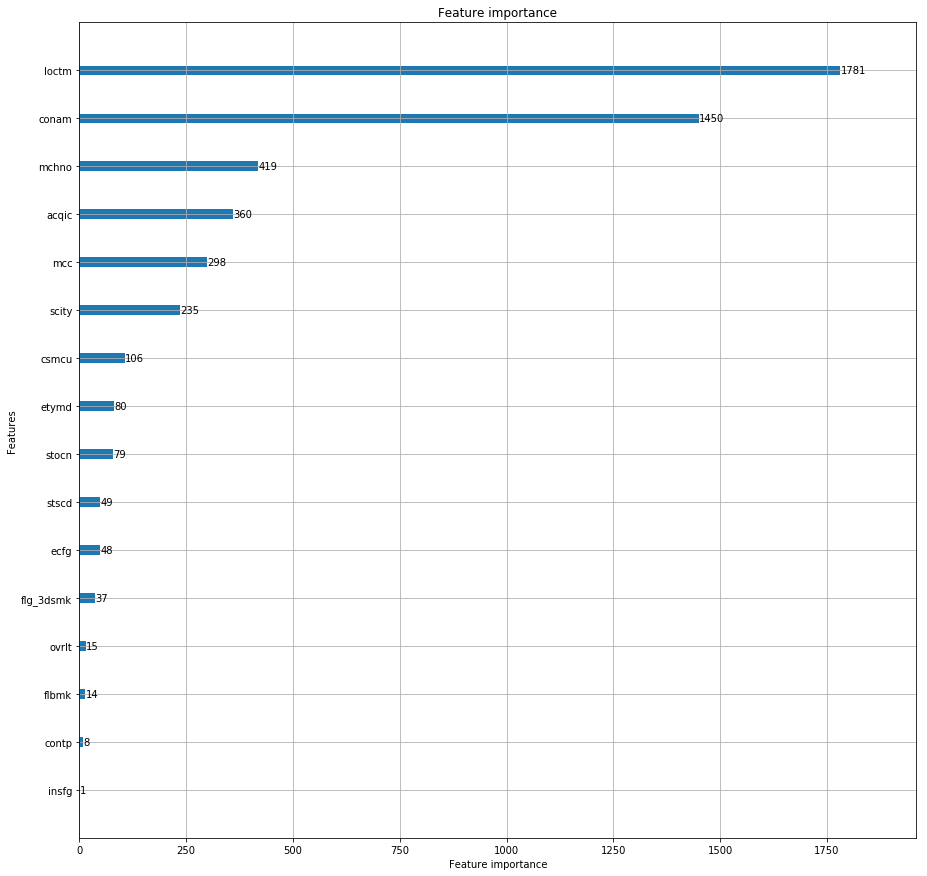

In [7]:
import lightgbm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import numpy as np

# f1 score
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat)
    return 'f1', f1_score(y_true, y_hat), True

# 超參數  
parameters = {
    #'boosting_type':'gbdt',
    #'n_estimators':64,
    'objective': 'cross_entropy',
    'metric': 'cross_entropy',
    'num_iterations':500,
    'learning_rate': 0.05,
    #'max_depth':10,
    #'num_leaves':64,
    'feature_fraction': 0.8,
    #'bagging_fraction' :0.9,
    #'reg_alpha':0.5,
    #'reg_lambda':0.5,
    'tree_learner':'data',
    "is_unbalance":True,
    "early_stopping_round":50,
    "drop_rate":0.5,
    #'min_child_samples':40,
    #'min_child_weight':0.002,
}

train_data = lightgbm.Dataset(train[features], 
                              label=train[y_name],
                              categorical_feature = features)

val_data = lightgbm.Dataset(val[features], 
                            label=val[y_name],
                            categorical_feature = features)

# training
evals_result = {}
model = lightgbm.train(parameters,
                       train_data, 
                       valid_sets=[val_data, train_data], 
                       valid_names=['val', 'train'], 
                       feval = lgb_f1_score,
                       evals_result = evals_result)

# plt 1
lightgbm.plot_metric(evals_result, metric='f1')
plt.show()

# plt 2
ax = lightgbm.plot_importance(model, max_num_features=40, figsize=(15,15))
plt.show()

# F1 report

In [8]:
from sklearn.metrics import classification_report 

#驗證集預測結果
y_pred = model.predict(val[features])
y_pred = pd.Series(y_pred).apply(round)
#驗證集分數
print(classification_report(val[y_name] ,y_pred ,target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    495493
           1       0.74      0.39      0.52      6697

    accuracy                           0.99    502190
   macro avg       0.87      0.70      0.76    502190
weighted avg       0.99      0.99      0.99    502190



# 產生submission

In [9]:
submission = pd.DataFrame()
submission["txkey"] = test_txkey

#測試集預測結果
submission["fraud_ind"] = model.predict(test[features])
submission["fraud_ind"] = submission["fraud_ind"].apply(round)

#value_counts
print(submission["fraud_ind"].value_counts())
submission.head()

0    418866
1      2799
Name: fraud_ind, dtype: int64


,txkey,fraud_ind
0,592489,0
1,592452,0
2,590212,0
3,590209,0
4,592488,0


# 保存

In [0]:
submission.to_csv("./submission_19.csv")